Notebook
https://www.learnpytorch.io/02_pytorch_classification/

## 0. Setup

In [249]:
%pip install torch torchvision torchaudio torchmetrics pandas numpy matplotlib tqdm scikit-learn;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [250]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm

In [251]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [252]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
print(f"Using {device} device")

Using mps device


## 1. Make Data

In this case, we will make a simple dataset of 1000 points. The points form 2 concentric circles. The inner circle contains points with label 1, and the outer circle contains points with label 0. The goal is to train a classifier that can predict the correct label given the x and y coordinates of a point.

In [253]:
# make 1000 samples
n_samples = 1000

# Create circles
X, Y = make_circles(n_samples, noise=0.03, random_state=seed)

# Print some samples
print(f"First 10 samples:\n{X[:10]}")
print(f"First 10 labels:\n{Y[:10]}")

First 10 samples:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First 10 labels:
[1 1 1 1 0 1 1 1 1 0]


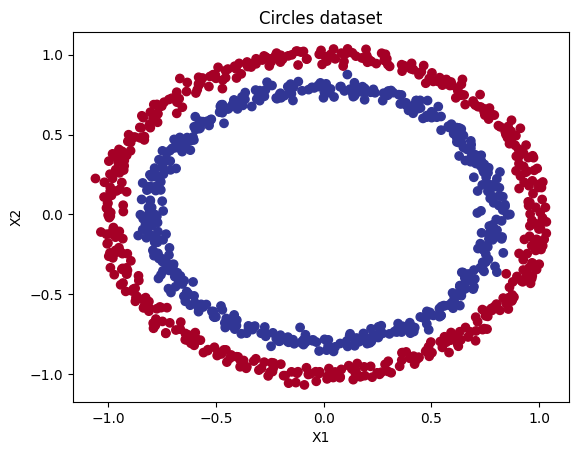

In [254]:
# Turns this into a dataframe
circles_df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": Y})


def plot_data(X, Y):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Circles dataset")

    plt.show()


plot_data(X, Y)

In [255]:
# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

# Convert to tensors
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Y_train, Y_test = torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()

# Move to device
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

## 2. Building the Model (a bad one)

In [256]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # Alternatively, you can use nn.Sequential
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.layer_1(x)
        y_logit = self.layer_2(x)

        return y_logit


def get_predictions(y_logits):
    y_pred = torch.round(torch.sigmoid(y_logits))
    return y_pred

In [257]:
model = CircleModelV0().to(device)

parameters = model.state_dict()
for name, param in parameters.items():
    print(f"Parameter {name}, shape: {param.shape}")

Parameter layer_1.weight, shape: torch.Size([5, 2])
Parameter layer_1.bias, shape: torch.Size([5])
Parameter layer_2.weight, shape: torch.Size([1, 5])
Parameter layer_2.bias, shape: torch.Size([1])


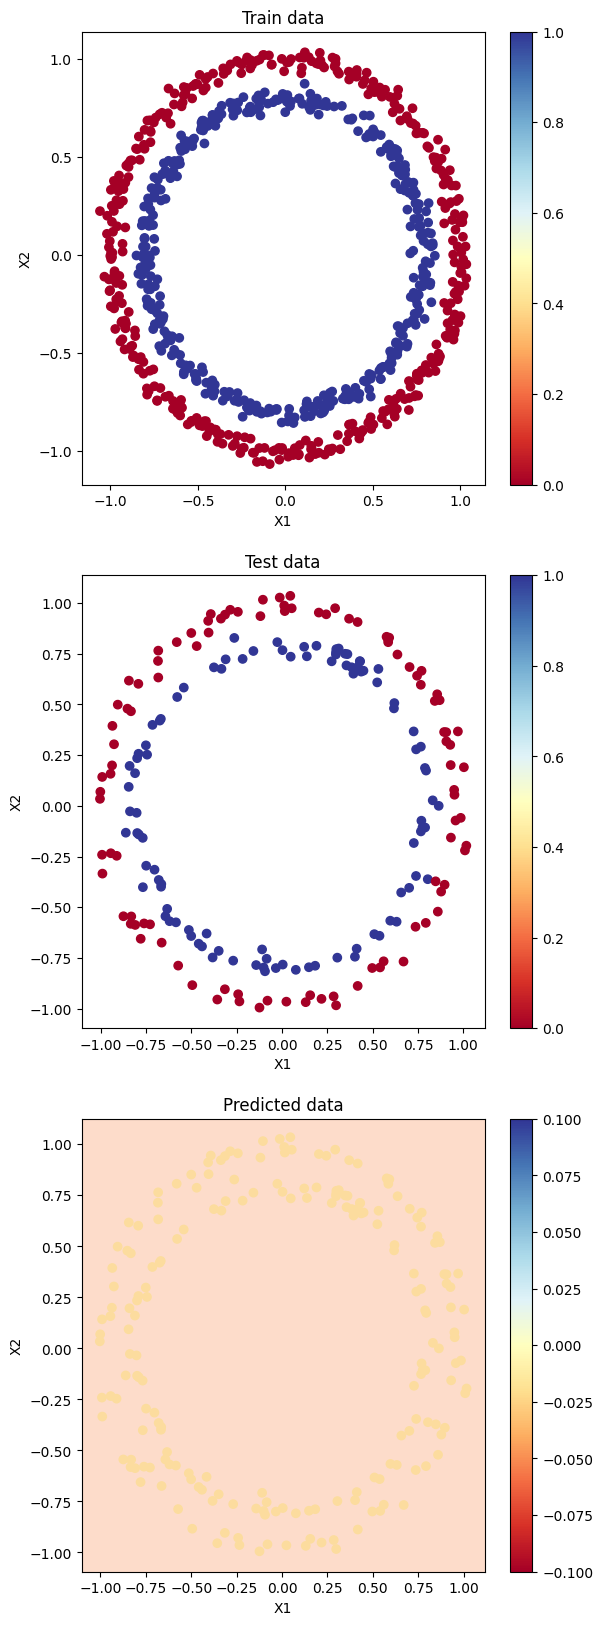

In [258]:
def plot_data(X_train, Y_train, X_test, Y_test, Y_pred=None, model=None):
    # figure with 3 columns
    plt.figure(figsize=(6.5, 20))

    plt.subplot(3, 1, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Train data")
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Test data")
    plt.colorbar()

    if Y_pred is not None:
        plt.subplot(3, 1, 3)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_pred, cmap=plt.cm.RdYlBu)
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title("Predicted data")
        plt.colorbar()

        if model is not None:
            # Plot Decision Boundary

            # get min and max for each dimension
            x1_min, x1_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1
            x2_min, x2_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1

            # create grid
            # x1 and x2 have n points each
            # Then xx1 and xx2 represent the matrix of all possible combinations of x1 and x2. So nxn points
            # xx1 and xx2 contain the corresponding x1 and x2 coordinates for each point in the grid
            x1 = np.arange(x1_min, x1_max, 0.01)
            x2 = np.arange(x2_min, x2_max, 0.01)
            xx1, xx2 = np.meshgrid(x1, x2)

            # make predictions for each point in the grid
            # Flatten the grid to get a list of all points with ravel
            # Then concatenate the x1 and x2 coordinates for each point in the grid
            X_grid = np.c_[xx1.ravel(), xx2.ravel()]
            X_grid = torch.from_numpy(X_grid).float().to(device)

            model.eval()
            with torch.inference_mode():
                Y_grid_logits = model(X_grid)
                Y_grid_pred = get_predictions(Y_grid_logits)

                # reshape predictions to the grid shape
                Y_grid_pred = Y_grid_pred.cpu().numpy().reshape(xx1.shape)

            # plot decision boundary
            plt.contourf(xx1, xx2, Y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.3)

    plt.show()


# make some predictions before training
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)

plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

### 3. Training the Model (a bad one)

Our model outs puts are logits, which we can convert into probabilities by passing them through an activation function (eg sigmoid for binary classification or softmax for multiclass classification). 

Then we can convert the probabilities into a predicted class by selecting the class with the highest probability. That is if the output after sigmoid is > 0.5, we predict class 1, otherwise we predict class 0.

In [259]:
def accuracy(Y_pred, Y_true):
    correct = torch.eq(Y_pred, Y_true).sum().item()
    return correct / Y_true.shape[0] * 100

In [260]:
def train(model, X_train, Y_train, X_test, Y_test, epochs, loss_fn, optimizer):
    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    train_loss, test_loss = [], []
    for epoch in tqdm(range(epochs), desc="Epochs", unit="epoch"):
        model.train()

        Y_train_logits = model(X_train).squeeze()

        # Normal BCE Loss would expect a probability between 0 and 1
        # So if we use BCE Loss, we need to apply sigmoid to the logits
        # Y_train_probs = torch.sigmoid(Y_train_logits)
        # loss = loss_fn(Y_train_probs, Y_train)

        # But we can use BCEWithLogitsLoss which combines sigmoid and BCE Loss
        train_loss = loss_fn(Y_train_logits, Y_train)
        accuracy_train = accuracy(get_predictions(Y_train_logits), Y_train)
        train_losses[epoch] = train_loss.item()

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            Y_test_logits = model(X_test).squeeze()

            test_loss = loss_fn(Y_test_logits, Y_test)
            accuracy_test = accuracy(get_predictions(Y_test_logits), Y_test)
            test_losses[epoch] = test_loss.item()

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch} | Train loss {train_loss:.3f} | Test loss {test_loss:.3f}"
            )
            print(
                f"Epoch {epoch} | Train accuracy {accuracy_train:.2f}% | Test accuracy {accuracy_test:.2f}%"
            )
            print("--------------------------------------------------")

    return train_losses, test_losses


loss_fn = nn.BCEWithLogitsLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, test_losses = train(
    model, X_train, Y_train, X_test, Y_test, 200, loss_fn, optimizer
)

Epochs:  22%|██▎       | 45/200 [00:00<00:00, 228.74epoch/s]

Epoch 0 | Train loss 0.696 | Test loss 0.696
Epoch 0 | Train accuracy 50.00% | Test accuracy 50.00%
--------------------------------------------------
Epoch 50 | Train loss 0.693 | Test loss 0.695
Epoch 50 | Train accuracy 51.00% | Test accuracy 46.00%
--------------------------------------------------


Epochs:  78%|███████▊  | 156/200 [00:00<00:00, 267.42epoch/s]

Epoch 100 | Train loss 0.693 | Test loss 0.695
Epoch 100 | Train accuracy 51.25% | Test accuracy 46.00%
--------------------------------------------------
Epoch 150 | Train loss 0.693 | Test loss 0.695
Epoch 150 | Train accuracy 51.12% | Test accuracy 46.00%
--------------------------------------------------


Epochs: 100%|██████████| 200/200 [00:00<00:00, 260.07epoch/s]


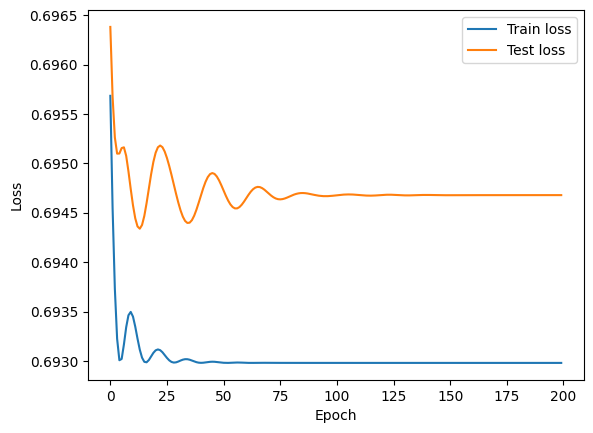

In [261]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


plot_losses(train_losses, test_losses)

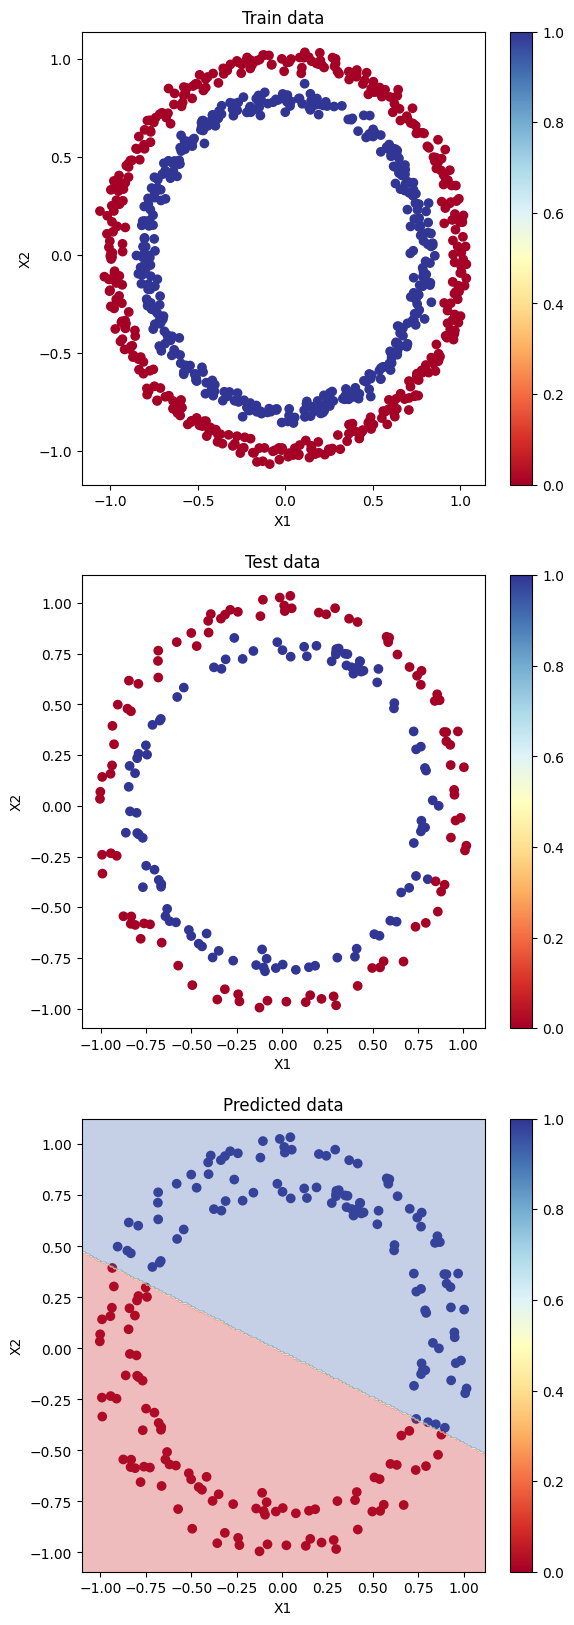

In [262]:
# Visualize the decision boundary
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)

plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

### 4. Building a Better Model

In [263]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [264]:
model = CircleModelV1().to(device)

parameters = model.state_dict()
for name, param in parameters.items():
    print(f"Parameter {name}, shape: {param.shape}")

Parameter layers.0.weight, shape: torch.Size([5, 2])
Parameter layers.0.bias, shape: torch.Size([5])
Parameter layers.2.weight, shape: torch.Size([5, 5])
Parameter layers.2.bias, shape: torch.Size([5])
Parameter layers.4.weight, shape: torch.Size([1, 5])
Parameter layers.4.bias, shape: torch.Size([1])


### 5. Training the Better Model

Epochs:   3%|▎         | 14/500 [00:00<00:03, 137.70epoch/s]

Epoch 0 | Train loss 0.693 | Test loss 0.692
Epoch 0 | Train accuracy 57.50% | Test accuracy 51.00%
--------------------------------------------------


Epochs:  16%|█▌        | 79/500 [00:00<00:02, 201.81epoch/s]

Epoch 50 | Train loss 0.625 | Test loss 0.641
Epoch 50 | Train accuracy 64.62% | Test accuracy 64.00%
--------------------------------------------------


Epochs:  24%|██▍       | 122/500 [00:00<00:01, 207.32epoch/s]

Epoch 100 | Train loss 0.465 | Test loss 0.511
Epoch 100 | Train accuracy 85.62% | Test accuracy 80.00%
--------------------------------------------------


Epochs:  37%|███▋      | 187/500 [00:00<00:01, 208.81epoch/s]

Epoch 150 | Train loss 0.327 | Test loss 0.382
Epoch 150 | Train accuracy 90.75% | Test accuracy 87.50%
--------------------------------------------------


Epochs:  46%|████▌     | 230/500 [00:01<00:01, 209.24epoch/s]

Epoch 200 | Train loss 0.200 | Test loss 0.263
Epoch 200 | Train accuracy 95.75% | Test accuracy 93.50%
--------------------------------------------------


Epochs:  54%|█████▍    | 272/500 [00:01<00:01, 207.71epoch/s]

Epoch 250 | Train loss 0.092 | Test loss 0.141
Epoch 250 | Train accuracy 99.62% | Test accuracy 98.50%
--------------------------------------------------


Epochs:  67%|██████▋   | 337/500 [00:01<00:00, 209.33epoch/s]

Epoch 300 | Train loss 0.060 | Test loss 0.107
Epoch 300 | Train accuracy 99.50% | Test accuracy 98.50%
--------------------------------------------------


Epochs:  76%|███████▌  | 380/500 [00:01<00:00, 209.84epoch/s]

Epoch 350 | Train loss 0.046 | Test loss 0.091
Epoch 350 | Train accuracy 99.62% | Test accuracy 98.50%
--------------------------------------------------


Epochs:  85%|████████▍ | 424/500 [00:02<00:00, 211.31epoch/s]

Epoch 400 | Train loss 0.037 | Test loss 0.082
Epoch 400 | Train accuracy 99.62% | Test accuracy 98.50%
--------------------------------------------------


Epochs:  98%|█████████▊| 490/500 [00:02<00:00, 211.92epoch/s]

Epoch 450 | Train loss 0.032 | Test loss 0.076
Epoch 450 | Train accuracy 99.62% | Test accuracy 98.50%
--------------------------------------------------


Epochs: 100%|██████████| 500/500 [00:02<00:00, 207.39epoch/s]


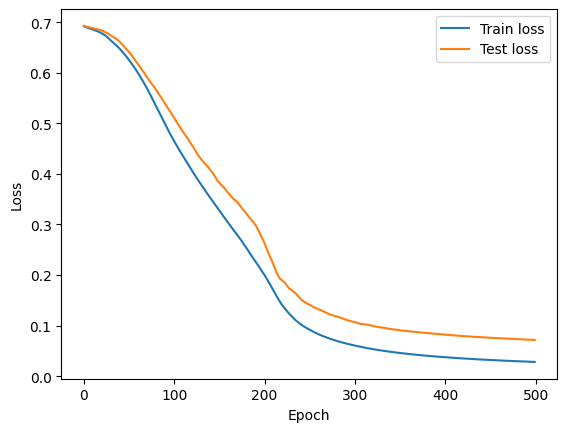

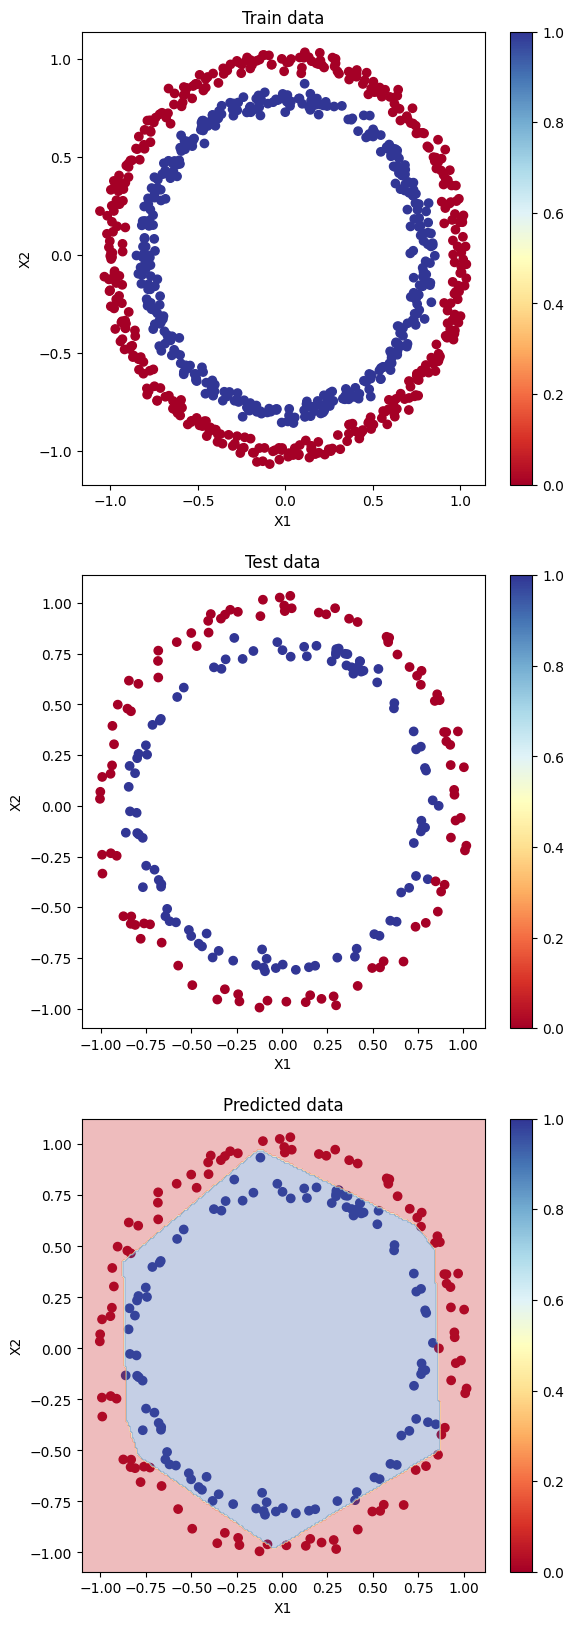

In [265]:
loss_fn = nn.BCEWithLogitsLoss()

lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, test_losses = train(
    model, X_train, Y_train, X_test, Y_test, 500, loss_fn, optimizer
)

# Visualize the loss
plot_losses(train_losses, test_losses)

# Visualize the decision boundary
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)
plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

## 6. Saving and Loading Models

In [266]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(exist_ok=True)

torch.save(model.state_dict(), model_path / "02_circle_model_v1.pth")

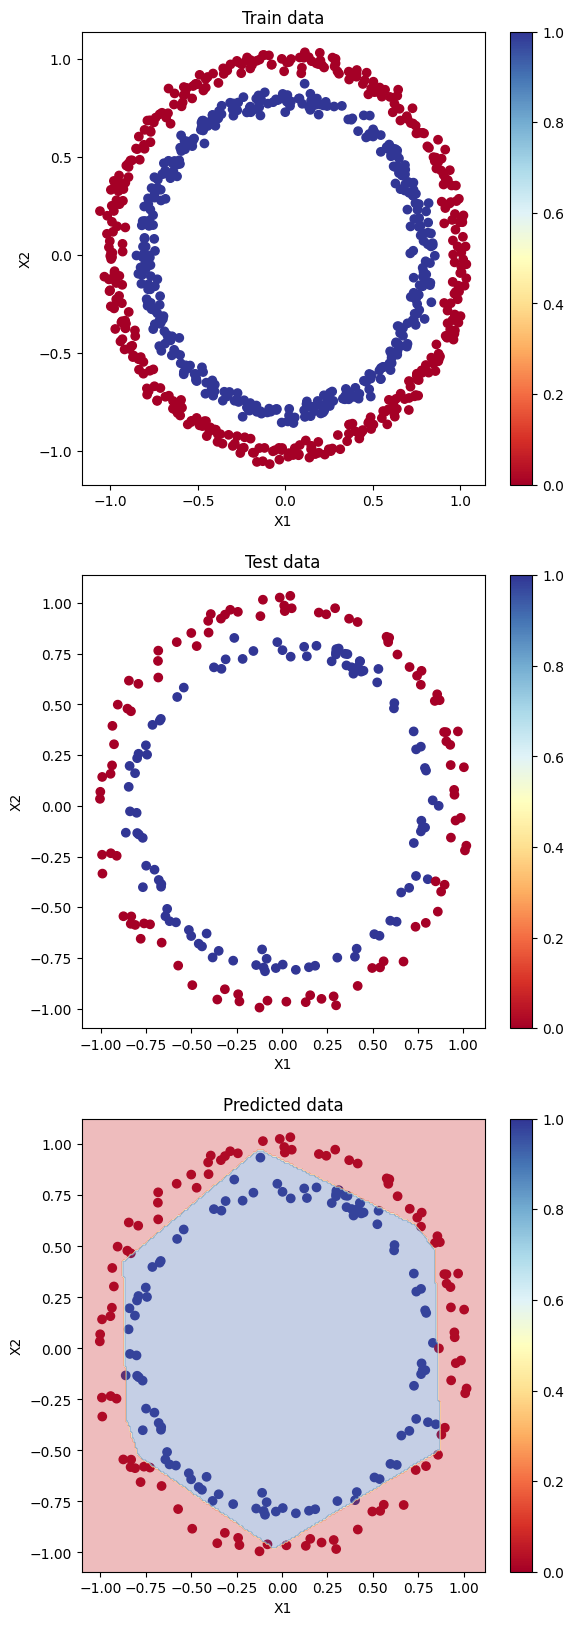

In [267]:
loaded_model = CircleModelV1().to(device)
loaded_model.load_state_dict(torch.load(model_path / "02_circle_model_v1.pth"))

# Visualize the decision boundary
loaded_model.eval()
with torch.inference_mode():
    Y_logits = loaded_model(X_test)
    Y_pred = get_predictions(Y_logits)
plot_data(
    X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), loaded_model
)

## 7. Make New Data (Mutli-class)

Now we will try to classify points into more than 2 classes.

In [268]:
from sklearn.datasets import make_blobs

In [269]:
def plot_data(X_train, Y_train, X_test, Y_test, Y_pred=None, model=None):
    # figure with 3 columns
    plt.figure(figsize=(6.5, 20))

    plt.subplot(3, 1, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Train data")
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Test data")
    plt.colorbar()

    if Y_pred is not None:
        plt.subplot(3, 1, 3)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_pred, cmap=plt.cm.RdYlBu)
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title("Predicted data")
        plt.colorbar()

        if model is not None:
            # Plot Decision Boundary

            # get min and max for each dimension
            x1_min, x1_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1
            x2_min, x2_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1

            # create grid
            # x1 and x2 have n points each
            # Then xx1 and xx2 represent the matrix of all possible combinations of x1 and x2. So nxn points
            # xx1 and xx2 contain the corresponding x1 and x2 coordinates for each point in the grid
            x1 = np.arange(x1_min, x1_max, 0.01)
            x2 = np.arange(x2_min, x2_max, 0.01)
            xx1, xx2 = np.meshgrid(x1, x2)

            # make predictions for each point in the grid
            # Flatten the grid to get a list of all points with ravel
            # Then concatenate the x1 and x2 coordinates for each point in the grid
            X_grid = np.c_[xx1.ravel(), xx2.ravel()]
            X_grid = torch.from_numpy(X_grid).float().to(device)

            model.eval()
            with torch.inference_mode():
                Y_pred_probs = model(X_grid)
                Y_grid_pred = torch.argmax(Y_pred_probs, dim=1)

                # reshape predictions to the grid shape
                Y_grid_pred = Y_grid_pred.cpu().numpy().reshape(xx1.shape)

            # plot decision boundary
            plt.contourf(xx1, xx2, Y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.3)

    plt.show()

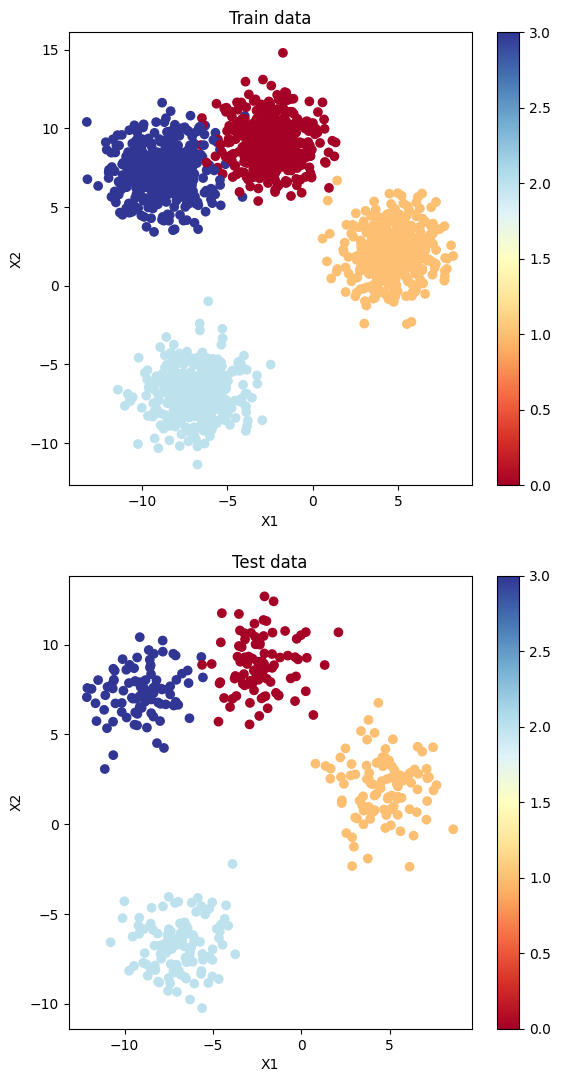

In [270]:
n_samples = 2000
n_classes = 4
n_features = 2
std = 1.5
X, Y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_classes,
    cluster_std=std,
    random_state=seed,
)

X, Y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
X, Y = X.to(device), Y.to(device)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)
plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu())

## 8. Building a Multi-class Model

In [271]:
class BlobModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, n_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [272]:
model = BlobModel(n_features, n_classes).to(device)

parameters = model.state_dict()
for name, param in parameters.items():
    print(f"Parameter {name}, shape: {param.shape}")

Parameter layers.0.weight, shape: torch.Size([10, 2])
Parameter layers.0.bias, shape: torch.Size([10])
Parameter layers.2.weight, shape: torch.Size([10, 10])
Parameter layers.2.bias, shape: torch.Size([10])
Parameter layers.4.weight, shape: torch.Size([4, 10])
Parameter layers.4.bias, shape: torch.Size([4])


## 9. Training the Multi-class Model

In [273]:
def train(X_train, X_test, Y_train, Y_test, model, loss_fn, optimizer, epochs):
    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    for epoch in range(epochs):
        model.train()

        Y_train_logits = model(X_train)

        train_loss = loss_fn(Y_train_logits, Y_train)
        train_losses[epoch] = train_loss.item()

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            Y_test_logits = model(X_test)
            test_loss = loss_fn(Y_test_logits, Y_test)

            test_losses[epoch] = test_loss.item()

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch} | Train loss {train_loss:.3f} | Test loss {test_loss:.3f}"
            )
            print("--------------------------------------------------")

    return train_losses, test_losses


loss_fn = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, test_losses = train(
    X_train, X_test, Y_train, Y_test, model, loss_fn, optimizer, 300
)

Epoch 0 | Train loss 1.233 | Test loss 1.112
--------------------------------------------------
Epoch 50 | Train loss 0.029 | Test loss 0.019
--------------------------------------------------
Epoch 100 | Train loss 0.027 | Test loss 0.018
--------------------------------------------------
Epoch 150 | Train loss 0.026 | Test loss 0.016
--------------------------------------------------
Epoch 200 | Train loss 0.025 | Test loss 0.015
--------------------------------------------------
Epoch 250 | Train loss 0.025 | Test loss 0.014
--------------------------------------------------


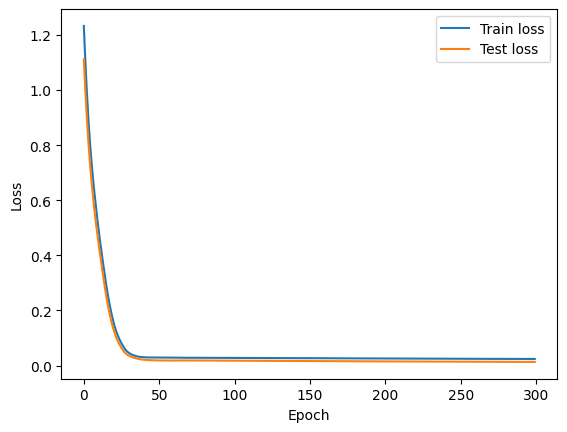

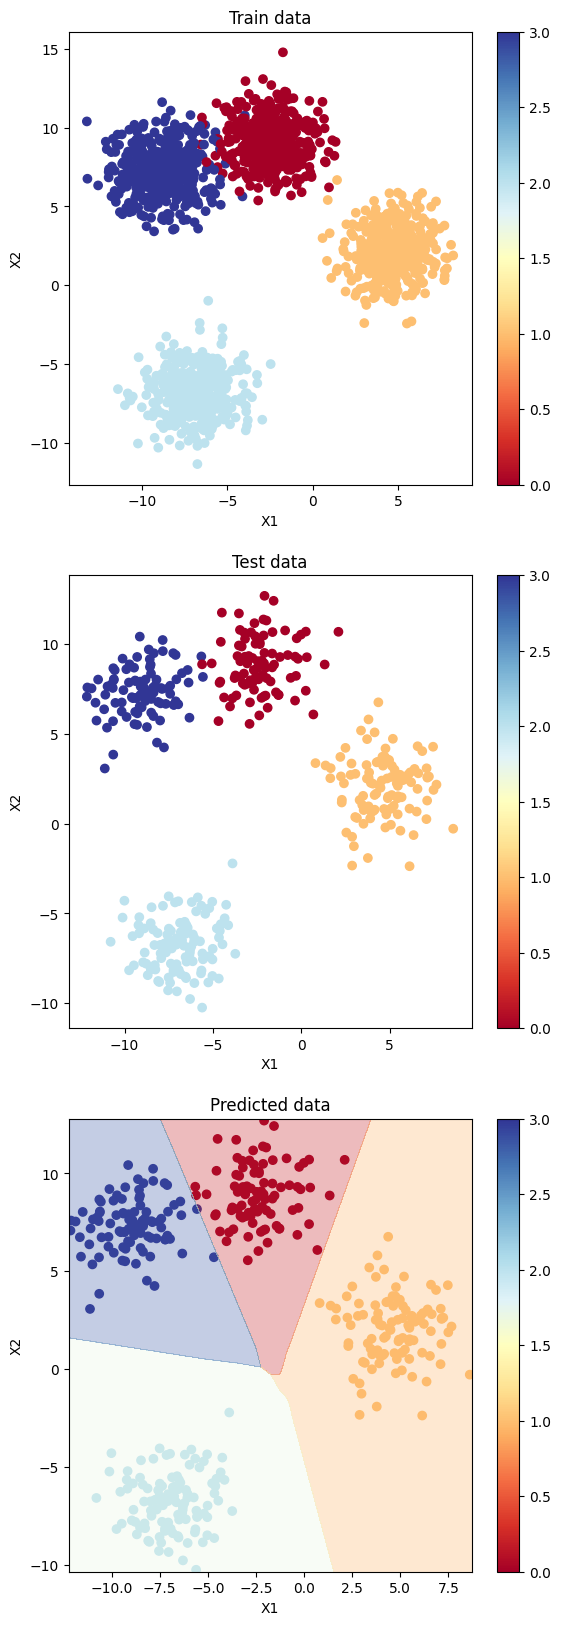

In [274]:
# Plot loss
plot_losses(train_losses, test_losses)

model.eval()
with torch.inference_mode():
    Y_pred_probs = model(X_test)
    # Set max index to 1 and the rest to 0
    Y_pred = torch.argmax(Y_pred_probs, dim=1)

# Visualize the decision boundary
plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

## 10. Saving and Loading Multi-class Models

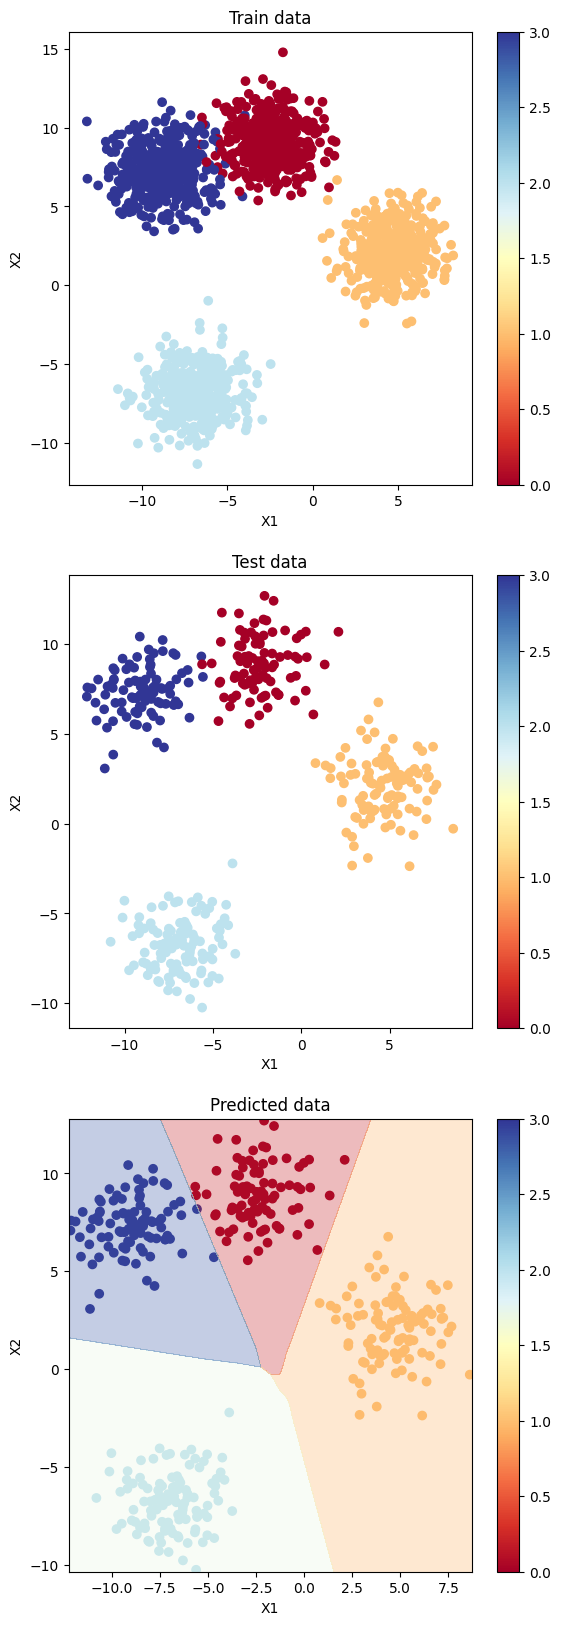

In [275]:
# Save model
torch.save(model.state_dict(), model_path / "02_blob_model.pth")

# Load model
loaded_model = BlobModel(n_features, n_classes).to(device)
loaded_model.load_state_dict(torch.load(model_path / "02_blob_model.pth"))

# Visualize the decision boundary
loaded_model.eval()
with torch.inference_mode():
    Y_pred_probs = loaded_model(X_test)
    Y_pred = torch.argmax(Y_pred_probs, dim=1)

plot_data(
    X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), loaded_model
)

## 11. Using some Torch Metrics

In [285]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
torchmetric_accuracy = torchmetric_accuracy.to(device)

# Make some predictions
model.eval()
with torch.inference_mode():
    Y_pred_probs = model(X_test)
    Y_pred = torch.argmax(Y_pred_probs, dim=1)

    

# Calculate accuracy
accuracy = torchmetric_accuracy(Y_pred, Y_test)*100
print(f"Accuracy: {accuracy}")

Accuracy: 100.0
